In [3]:
# ============================================================================
# CONFIGURATION DU NOTEBOOK
# ============================================================================

import datetime


# Configuration MLflow
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
MLFLOW_EXPERIMENT_NAME = "OC_P6_Credit_Scoring"

# Configuration du projet
PROJECT_VERSION = "1.0"
MODEL_NAME = "LightGBM"
NOTEBOOK_NAME = "03_LGBM"
RUN_DATE = datetime.datetime.now()

# Configuration des données
DATA_PATH = "../data/processed/"
TRAIN_FILE = "features_train.csv"
TEST_FILE = "features_test.csv"

# Configuration du modèle baseline
MODEL_CONFIG = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "num_leaves": 31,
    "class_weight": "balanced",
    "random_state": 42
}

# Configuration de la validation
VALIDATION_SPLIT_RATIO = 0.2
RANDOM_STATE = 42

# Configuration des tags MLflow
MLFLOW_TAGS = {
    "project_version": PROJECT_VERSION,
    "notebook": NOTEBOOK_NAME,
    "phase": "baseline",
    "desequilibre_handling": "class_weight_balanced",
    "date": RUN_DATE,
}

print("Configuration chargée avec succès !")
print(f"MLflow Experiment: {MLFLOW_EXPERIMENT_NAME}")
print(f"Project Version: {PROJECT_VERSION}")
print(f"Model: {MODEL_NAME}")


Configuration chargée avec succès !
MLflow Experiment: OC_P6_Credit_Scoring
Project Version: 1.0
Model: LightGBM


# 03 - LightGBM Modeling with MLflow Tracking

Configuration and experimentation notebook for credit scoring model.
All runs will be tracked in MLflow for comparison and reproducibility.

In [4]:
from src.mlflow_config import configure_mlflow

mlflow = configure_mlflow(autolog=False)

2026/02/04 23:38:11 INFO mlflow.tracking.fluent: Experiment with name 'OC_P6_Credit_Scoring' does not exist. Creating a new experiment.


In [5]:
# ============================================================================
# CLEANUP & VERIFICATION (Optionnel mais recommandé)
# ============================================================================
from mlflow.tracking import MlflowClient

client = MlflowClient(MLFLOW_TRACKING_URI)

# Récupérer l'expérience
experiment = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
experiment_id = experiment.experiment_id if experiment else "0"

print("📊 État MLflow au démarrage:")
print(f"   Expérience: {MLFLOW_EXPERIMENT_NAME} (ID: {experiment_id})")

# Récupérer les runs actuels
runs = client.search_runs(experiment_ids=[experiment_id])
print(f"   Nombre de runs existants: {len(runs)}")

# Liste des runs attendus (clean)
EXPECTED_RUN_NAMES = {
    "LGBM_baseline_CV",
    "LGBM_optuna_tuning",
    "best_params_cv_evaluation",  # enfant
    "final_model",                 # enfant
    "LGBM_final_validation",
    "LGBM_final_interpretability",
    "LightGBM_baseline_1.0"
}

# Détecter les runs parasites
actual_run_names = {run.data.tags.get("mlflow.runName", "unknown") for run in runs}
parasite_runs = actual_run_names - EXPECTED_RUN_NAMES

if parasite_runs:
    print(f"\n⚠️  Runs parasites détectés: {parasite_runs}")
    print("   Pour les supprimer, dé-commenter les lignes ci-dessous:")
    print("   # for run in runs:")
    print("   #     if run.data.tags.get('mlflow.runName') in parasite_runs:")
    print("   #         client.delete_run(run.info.run_id)")
else:
    print("\n✅ Aucun run parasite détecté")

📊 État MLflow au démarrage:
   Expérience: OC_P6_Credit_Scoring (ID: 1)
   Nombre de runs existants: 0

✅ Aucun run parasite détecté


In [6]:
import pandas as pd

# Exemple si tu as sauvegardé les features
X_train = pd.read_csv("../data/processed/features_train.csv")
y_train = X_train.pop("TARGET")  # ou le nom de ta cible
# Même chose pour X_val, y_val si tu as un split

In [7]:
# ============================================================================
# Cross-validation LightGBM + coût métier
# ============================================================================
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import warnings

# Désactiver le warning MLflow pip
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')

# Nettoyage des colonnes avant entraînement (noms + types)
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    for col in object_cols:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
X_train.columns = (
    X_train.columns
    .str.replace(' ', '_')
    .str.replace('[^a-zA-Z0-9_]', '_', regex=True)
    .str.replace('__+', '_', regex=True)
)

# Paramètres modèle (assurer class_weight=balanced)
MODEL_CONFIG_CV = {**MODEL_CONFIG, "class_weight": "balanced"}

# K-Fold stratifié
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_results = []
thresholds = np.round(np.arange(0.1, 0.91, 0.05), 2)

RUN_NAME_CV = "LGBM_baseline_CV"

with mlflow.start_run(run_name=RUN_NAME_CV):
    # Log paramètres
    mlflow.log_params(MODEL_CONFIG_CV)
    
    # Log tags existants
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "baseline_cv")
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LGBMClassifier(**MODEL_CONFIG_CV)
        model.fit(X_tr, y_tr)
        
        y_val_proba = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_proba)
        
        best_threshold = None
        min_cost = None
        best_fp = None
        best_fn = None
        
        for thr in thresholds:
            y_val_pred = (y_val_proba >= thr).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
            cost = 10 * fn + 1 * fp
            if (min_cost is None) or (cost < min_cost):
                min_cost = cost
                best_threshold = thr
                best_fp = fp
                best_fn = fn
        
        fold_results.append({
            "fold": fold_idx,
            "auc": auc,
            "best_threshold": best_threshold,
            "min_cost": min_cost,
            "fp": best_fp,
            "fn": best_fn
        })
    
    cv_results_df = pd.DataFrame(fold_results)
    cv_auc_mean = cv_results_df["auc"].mean()
    cv_min_cost_mean = cv_results_df["min_cost"].mean()
    cv_best_threshold_mean = cv_results_df["best_threshold"].mean()
    
    # Log métriques moyennes
    mlflow.log_metric("cv_auc_mean", cv_auc_mean)
    mlflow.log_metric("cv_min_cost_mean", cv_min_cost_mean)
    mlflow.log_metric("cv_best_threshold_mean", cv_best_threshold_mean)
    
    # Log artefact JSON
    mlflow.log_dict(cv_results_df.to_dict(orient="records"), "cv_results.json")
    
    print("✓ Cross-validation terminée")
    print(f"AUC moyen: {cv_auc_mean:.4f}")
    print(f"Coût métier moyen: {cv_min_cost_mean:.2f}")
    print(f"Seuil optimal moyen: {cv_best_threshold_mean:.2f}")

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19266
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 644
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19578
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 646
[LightGBM] [Info] [binar

In [8]:
# ============================================================================
# Optimisation RAPIDE Optuna (~10 min max)
# ============================================================================
import optuna
from optuna.pruners import MedianPruner
import warnings

# Désactiver le warning MLflow pip
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')

print("\n" + "="*70)
print("🔧 OPTUNA OPTIMIZATION - Fast iteration")
print("="*70)

# Seuils grossiers pour vitesse (6 valeurs)
thresholds_optuna = np.arange(0.2, 0.8, 0.1)

# CV accélérée : 3 folds
skf_optuna = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ==========================================================================
# FONCTION UTILITAIRE : Calcul du coût métier minimal par fold
# ==========================================================================
def compute_min_cost_per_fold(y_true, y_proba, thresholds_array):
    """
    Trouve le seuil optimal qui minimise le coût métier.
    Coût = 10 * FN + 1 * FP
    """
    min_cost = float('inf')
    best_threshold = 0.5
    
    for thr in thresholds_array:
        y_pred = (y_proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = 10 * fn + 1 * fp
        
        if cost < min_cost:
            min_cost = cost
            best_threshold = thr
    
    return min_cost, best_threshold

# ==========================================================================
# OBJECTIVE OPTUNA
# ==========================================================================
def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 31, 128),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.1, log=True),
        "n_estimators": 500,
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 80),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "class_weight": "balanced",
        "random_state": 42,
        "verbose": -1,
    }
    
    fold_costs = []
    for train_idx, val_idx in skf_optuna.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        
        y_val_proba = model.predict_proba(X_val)[:, 1]
        min_cost, _ = compute_min_cost_per_fold(y_val, y_val_proba, thresholds_optuna)
        fold_costs.append(min_cost)
        
        trial.report(np.mean(fold_costs), step=len(fold_costs)-1)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return -np.mean(fold_costs)

# ==========================================================================
# LANCEMENT OPTUNA DANS UN RUN PARENT
# ==========================================================================
print("\n🚀 Lancement Optuna: 15 trials, 3-fold CV, timeout=600s...")

with mlflow.start_run(run_name="LGBM_optuna_tuning") as parent_run:
    # Tags du run parent
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "optuna_tuning")
    
    # Optuna optimization
    pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=15, timeout=600, show_progress_bar=True)
    
    # Récupérer best_params
    best_params = study.best_params.copy()
    best_params["class_weight"] = "balanced"
    best_params["random_state"] = 42
    best_params["n_estimators"] = 500
    best_params["verbose"] = -1
    
    print(f"\n✓ Optuna terminé: {len(study.trials)} trials")
    print(f"Best params: {best_params}")
    print(f"Best score (negative cost): {study.best_value:.2f}")
    
    # Log des paramètres Optuna
    mlflow.log_params(best_params)
    mlflow.log_metric("optuna_best_score", study.best_value)
    mlflow.log_metric("optuna_n_trials", len(study.trials))
    
    # ==========================================================================
    # RE-ÉVALUATION EN CV AVEC LES MEILLEURS PARAMÈTRES (nested run)
    # ==========================================================================
    print("\n📊 Évaluation finale en CV avec best_params...")
    
    with mlflow.start_run(run_name="best_params_cv_evaluation", nested=True):
        best_fold_results = []
        for fold_idx, (train_idx, val_idx) in enumerate(skf_optuna.split(X_train, y_train), start=1):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model = LGBMClassifier(**best_params)
            model.fit(X_tr, y_tr)
            
            y_val_proba = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_val_proba)
            min_cost, best_thr = compute_min_cost_per_fold(y_val, y_val_proba, thresholds_optuna)
            
            best_fold_results.append({
                "fold": fold_idx,
                "auc": auc,
                "best_threshold": best_thr,
                "min_cost": min_cost
            })
        
        best_cv_df = pd.DataFrame(best_fold_results)
        best_cv_auc_mean = best_cv_df["auc"].mean()
        best_cv_min_cost_mean = best_cv_df["min_cost"].mean()
        best_cv_best_threshold_mean = best_cv_df["best_threshold"].mean()
        
        mlflow.log_metric("cv_auc_mean", best_cv_auc_mean)
        mlflow.log_metric("cv_min_cost_mean", best_cv_min_cost_mean)
        mlflow.log_metric("cv_best_threshold_mean", best_cv_best_threshold_mean)
        mlflow.log_dict(best_cv_df.to_dict(orient="records"), "cv_results.json")
        
        print(f"\n✓ Résultats CV (best_params):")
        print(f"  AUC moyen: {best_cv_auc_mean:.4f}")
        print(f"  Coût métier moyen: {best_cv_min_cost_mean:.2f}")
        print(f"  Seuil optimal moyen: {best_cv_best_threshold_mean:.2f}")
    
    # ==========================================================================
    # MODÈLE FINAL (nested run)
    # ==========================================================================
    with mlflow.start_run(run_name="final_model", nested=True):
        mlflow.log_params(best_params)
        
        final_model = LGBMClassifier(**best_params)
        final_model.fit(X_train, y_train)
        
        mlflow.lightgbm.log_model(final_model, name=MODEL_NAME)
        
        print("\n✅ Run MLflow 'LGBM_optuna_tuning' terminé avec nested runs")


🔧 OPTUNA OPTIMIZATION - Fast iteration

🚀 Lancement Optuna: 15 trials, 3-fold CV, timeout=600s...


[I 2026-02-04 23:38:21,683] A new study created in memory with name: no-name-c4d64fcb-4096-4e82-b2b8-a02467422963


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2026-02-04 23:38:24,863] Trial 0 finished with value: -1974.0 and parameters: {'num_leaves': 103, 'max_depth': 6, 'learning_rate': 0.04401323505184173, 'min_child_samples': 31, 'subsample': 0.7660221226568005, 'colsample_bytree': 0.985846282828339}. Best is trial 0 with value: -1974.0.
[I 2026-02-04 23:38:28,027] Trial 1 finished with value: -2137.6666666666665 and parameters: {'num_leaves': 58, 'max_depth': 7, 'learning_rate': 0.0758151699339011, 'min_child_samples': 32, 'subsample': 0.9509321447681661, 'colsample_bytree': 0.8564285026964316}. Best is trial 0 with value: -1974.0.
[I 2026-02-04 23:38:31,840] Trial 2 finished with value: -2244.3333333333335 and parameters: {'num_leaves': 63, 'max_depth': 9, 'learning_rate': 0.09607569798355543, 'min_child_samples': 59, 'subsample': 0.9353667917149061, 'colsample_bytree': 0.964563549785599}. Best is trial 0 with value: -1974.0.
[I 2026-02-04 23:38:42,637] Trial 3 finished with value: -2301.3333333333335 and parameters: {'num_leaves': 

2026/02/04 23:39:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Run MLflow 'LGBM_optuna_tuning' terminé avec nested runs
🏃 View run final_model at: http://127.0.0.1:5000/#/experiments/1/runs/89adc63488084b34b5ad0163495294a1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🏃 View run LGBM_optuna_tuning at: http://127.0.0.1:5000/#/experiments/1/runs/3e2cec8434484203b72657bf3f7a8946
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


🔀 Hold-out split:
   Train: 8000 | Hold-out: 2000
✓ Utilisation des best_params d'Optuna

🚀 Entraînement du modèle final...
✓ Modèle final entraîné

📊 Hold-out AUC-ROC: 0.7534
🎯 Seuil optimal : 0.49
💰 Coût minimal : 1051.00
📈 F1-score (seuil optimal) : 0.2579
📈 Recall classe 1 (seuil optimal) : 0.6839

📊 Plot sauvegardé : /home/valentin/Env_Python/OC_P6/threshold_cost_curve.png


2026/02/04 23:39:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Run MLflow 'LGBM_final_validation' terminé
   📊 Métriques : AUC=0.7534, Min Cost=1051.00, F1=0.2579
   🎯 Seuil optimal : 0.49
🏃 View run LGBM_final_validation at: http://127.0.0.1:5000/#/experiments/1/runs/4d7905b82a09447cada96f481c26095e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


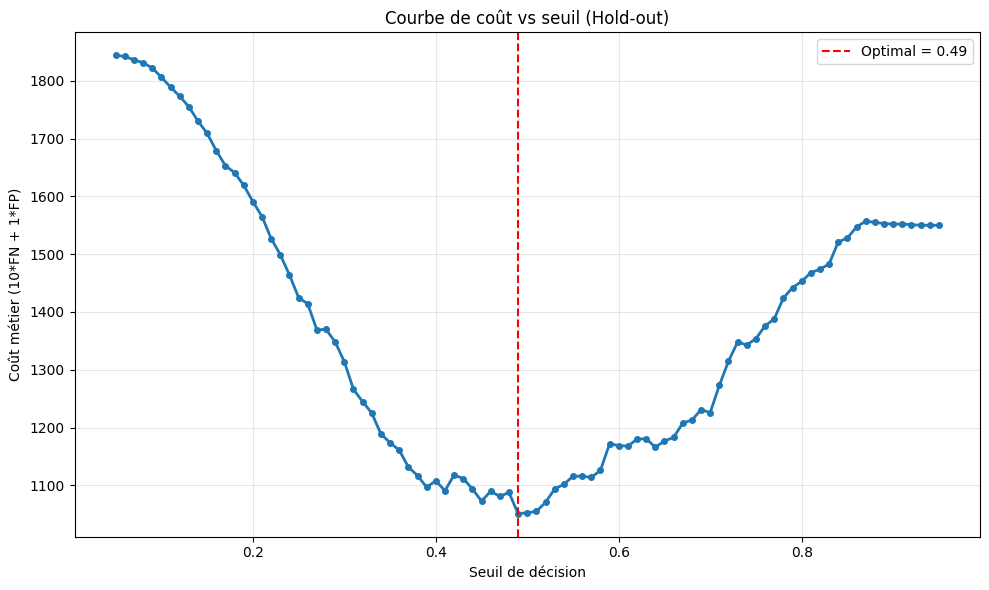

In [9]:
# ============================================================================
# SECTION FINALE : Validation & Optimisation du seuil métier (Hold-out)
# ============================================================================
# WHY HOLD-OUT :
# - Valide la généralisation (évite overfitting de la CV)
# - Évalue le modèle sur données jamais vues pendant Optuna
# - Reflète mieux la performance en production
#
# WHY SEUIL FIN ICI (pas dans Optuna) :
# - Optuna avec seuils grossiers (0.2-0.7, step 0.1) : ~10 min, peu de précision
# - Seuil fin (0.05-0.95, step 0.01) : ici rapidement sans ralentir optimisation
# ============================================================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import warnings

# Désactiver le warning MLflow pip
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')

# 1. Créer le hold-out stratifié (20% test, 80% train)
X_train_final, X_holdout, y_train_final, y_holdout = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    stratify=y_train, 
    random_state=RANDOM_STATE
)

print(f"🔀 Hold-out split:")
print(f"   Train: {X_train_final.shape[0]} | Hold-out: {X_holdout.shape[0]}")

# 2. Utiliser best_params d'Optuna (doit venir de la cellule précédente)
# Si best_params n'existe pas, utiliser des valeurs par défaut
try:
    _ = best_params
    print(f"✓ Utilisation des best_params d'Optuna")
except NameError:
    best_params = {
        'num_leaves': 90,
        'max_depth': 8,
        'learning_rate': 0.035,
        'n_estimators': 500,
        'min_child_samples': 50,
        'subsample': 0.7,
        'colsample_bytree': 0.9,
        'class_weight': 'balanced',
        'random_state': 42,
        'verbose': -1,
    }
    print("⚠ best_params non trouvé, utilisation des valeurs par défaut")

# S'assurer que verbose est défini
if 'verbose' not in best_params:
    best_params['verbose'] = -1

# 3. Entraîner le modèle final sur 80%
print("\n🚀 Entraînement du modèle final...")
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_final, y_train_final)
print("✓ Modèle final entraîné")

# 4. Prédire probabilités sur hold-out
y_holdout_proba = final_model.predict_proba(X_holdout)[:, 1]

# 5. Calculer AUC-ROC sur hold-out
holdout_auc = roc_auc_score(y_holdout, y_holdout_proba)
print(f"\n📊 Hold-out AUC-ROC: {holdout_auc:.4f}")

# 6. Optimisation FINE du seuil (0.05-0.95, step 0.01)
fine_thresholds = np.arange(0.05, 0.96, 0.01)
threshold_costs = []

for thr in fine_thresholds:
    y_holdout_pred = (y_holdout_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_holdout, y_holdout_pred).ravel()
    cost = 10 * fn + 1 * fp
    threshold_costs.append({
        'threshold': thr,
        'cost': cost,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    })

threshold_costs_df = pd.DataFrame(threshold_costs)
optimal_idx = threshold_costs_df['cost'].idxmin()
optimal_threshold = threshold_costs_df.loc[optimal_idx, 'threshold']
min_cost = threshold_costs_df.loc[optimal_idx, 'cost']

print(f"🎯 Seuil optimal : {optimal_threshold:.2f}")
print(f"💰 Coût minimal : {min_cost:.2f}")

# 7. Calculer F1 et Recall au seuil optimal
y_holdout_optimal = (y_holdout_proba >= optimal_threshold).astype(int)
holdout_f1 = f1_score(y_holdout, y_holdout_optimal)
holdout_recall = recall_score(y_holdout, y_holdout_optimal)

print(f"📈 F1-score (seuil optimal) : {holdout_f1:.4f}")
print(f"📈 Recall classe 1 (seuil optimal) : {holdout_recall:.4f}")

# 8. Tracer la courbe coût vs seuil
plt.figure(figsize=(10, 6))
plt.plot(threshold_costs_df['threshold'], threshold_costs_df['cost'], 
         marker='o', linewidth=2, markersize=4)
plt.axvline(optimal_threshold, color='red', linestyle='--', 
            label=f'Optimal = {optimal_threshold:.2f}')
plt.xlabel('Seuil de décision')
plt.ylabel('Coût métier (10*FN + 1*FP)')
plt.title('Courbe de coût vs seuil (Hold-out)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Sauvegarder le plot
plot_path = '/home/valentin/Env_Python/OC_P6/threshold_cost_curve.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n📊 Plot sauvegardé : {plot_path}")

# 9. Log MLflow (RUN INDÉPENDANT - après Optuna, avec résultats finaux)
with mlflow.start_run(run_name="LGBM_final_validation"):
    # Log params
    mlflow.log_params(best_params)
    
    # Log tags
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "final_validation")
    mlflow.set_tag("validation_method", "hold-out_20pct")
    
    # Log metrics
    mlflow.log_metric("holdout_auc", holdout_auc)
    mlflow.log_metric("holdout_min_cost", min_cost)
    mlflow.log_metric("optimal_threshold", optimal_threshold)
    mlflow.log_metric("holdout_f1", holdout_f1)
    mlflow.log_metric("holdout_recall", holdout_recall)
    
    # Log plot
    mlflow.log_artifact(plot_path)
    
    # Log tableau des coûts par décile (JSON)
    decile_costs = threshold_costs_df[::10].to_dict(orient='records')
    mlflow.log_dict(decile_costs, "threshold_costs_deciles.json")
    
    # Log du modèle
    mlflow.lightgbm.log_model(final_model, name=MODEL_NAME)
    
    print(f"\n✅ Run MLflow 'LGBM_final_validation' terminé")
    print(f"   📊 Métriques : AUC={holdout_auc:.4f}, Min Cost={min_cost:.2f}, F1={holdout_f1:.4f}")
    print(f"   🎯 Seuil optimal : {optimal_threshold:.2f}")

## Interprétabilité (global + local) avec SHAP
SHAP est pertinent pour la transparence métier car il fournit une attribution **cohérente et locale** des contributions de chaque variable à une décision, tout en restant **agrégeable au niveau global**. Cela permet d’expliquer un score client individuel (force plot) et de justifier les facteurs principaux à l’échelle du portefeuille (summary plot), ce qui est attendu en contexte de scoring de crédit.

In [10]:
# ============================================================================
# Modèle final + Feature importance + SHAP (optionnel)
# ============================================================================
import os
from pathlib import Path
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

# Désactiver les warnings MLflow
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')
warnings.filterwarnings('ignore', message='.*Inferred schema contains integer column.*')

# Entraîner le modèle final sur tout le train set
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

with mlflow.start_run(run_name="LGBM_final_interpretability"):
    # Tags + params
    mlflow.log_params(best_params)
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    mlflow.set_tag("model_type", MODEL_NAME)
    mlflow.set_tag("phase", "final_interpretability")
    
    # Log du modèle final
    mlflow.lightgbm.log_model(final_model, name=MODEL_NAME)
    
    # --- Feature importance globale (gain) ---
    fig_gain, ax_gain = plt.subplots(figsize=(8, 6))
    lgb.plot_importance(final_model, importance_type="gain", ax=ax_gain, max_num_features=30)
    ax_gain.set_title("Feature Importance (Gain)")
    mlflow.log_figure(fig_gain, "feature_importance_gain.png")
    plt.close(fig_gain)
    
    # --- Feature importance globale (split) ---
    fig_split, ax_split = plt.subplots(figsize=(8, 6))
    lgb.plot_importance(final_model, importance_type="split", ax=ax_split, max_num_features=30)
    ax_split.set_title("Feature Importance (Split)")
    mlflow.log_figure(fig_split, "feature_importance_split.png")
    plt.close(fig_split)
    
    # --- SHAP : interprétabilité locale & globale (optionnel - peut avoir incompatibilités) ---
    try:
        import shap
        print("\n📊 Calcul des SHAP values...")
        
        sample_size = min(1000, len(X_train))
        X_sample = X_train.sample(n=sample_size, random_state=42)
        
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_sample)
        
        # Pour binaire, shap_values peut être une liste [classe0, classe1]
        if isinstance(shap_values, list):
            shap_values_to_use = shap_values[1]
        else:
            shap_values_to_use = shap_values
        
        # Summary plot (bee swarm)
        shap.summary_plot(shap_values_to_use, X_sample, show=False)
        fig_summary = plt.gcf()
        fig_summary.set_size_inches(10, 6)
        mlflow.log_figure(fig_summary, "shap_summary_beeswarm.png")
        plt.close(fig_summary)
        
        # Force plots pour 5 clients aléatoires
        force_dir = Path("shap_force_plots")
        force_dir.mkdir(parents=True, exist_ok=True)
        rng = np.random.default_rng(42)
        sample_indices = rng.choice(X_sample.index, size=min(5, len(X_sample)), replace=False)
        
        for i, idx in enumerate(sample_indices, start=1):
            force_plot = shap.force_plot(
                explainer.expected_value if not isinstance(explainer.expected_value, (list, tuple)) else explainer.expected_value[1],
                shap_values_to_use[X_sample.index.get_loc(idx)],
                X_sample.loc[idx],
                matplotlib=False
            )
            force_path = force_dir / f"shap_force_plot_{i}.html"
            shap.save_html(str(force_path), force_plot)
            mlflow.log_artifact(str(force_path))
        
        print("✓ Artefacts SHAP loggés dans MLflow")
    
    except (ImportError, TypeError) as e:
        print(f"⚠ SHAP non disponible ou incompatibilité: {str(e)[:80]}...")
        print("  - Les feature importance (gain/split) sont loggées")
        print("  - Pour SHAP: pip install --upgrade shap scikit-learn")
    
    print("✓ Modèle final et feature importance loggés dans MLflow")

2026/02/04 23:39:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


⚠ SHAP non disponible ou incompatibilité: Converting `np.inexact` or `np.floating` to a dtype not allowed...
  - Les feature importance (gain/split) sont loggées
  - Pour SHAP: pip install --upgrade shap scikit-learn
✓ Modèle final et feature importance loggés dans MLflow
🏃 View run LGBM_final_interpretability at: http://127.0.0.1:5000/#/experiments/1/runs/b2c66173d0c54793b6303d8d42ff8174
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [11]:
# Convertir les colonnes object en types numériques
import numpy as np

# Identifier et convertir les colonnes object
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Colonnes object détectées: {object_cols}")

# Convertir chaque colonne object en numeric
for col in object_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    # Remplacer les NaN introduits par la conversion par 0
    X_train[col] = X_train[col].fillna(0)

# Nettoyer les noms de colonnes (remplacer les caractères spéciaux)
X_train.columns = X_train.columns.str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Vérifier que toutes les colonnes sont numériques
print(f"Dtypes après conversion:\n{X_train.dtypes.value_counts()}")
print(f"\nColonnes (exemples): {X_train.columns[:5].tolist()}")

Colonnes object détectées: []
Dtypes après conversion:
float64    568
bool       131
int64       42
Name: count, dtype: int64

Colonnes (exemples): ['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']


## Runs de modèles
Les entraînements et le logging MLflow commencent ici.

In [12]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
import warnings

# Désactiver les warnings MLflow
warnings.filterwarnings('ignore', message='.*Failed to resolve installed pip version.*')
warnings.filterwarnings('ignore', message='.*Inferred schema contains integer column.*')

# Split si pas déjà fait
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, 
    test_size=VALIDATION_SPLIT_RATIO, 
    stratify=y_train, 
    random_state=RANDOM_STATE
)

# Appliquer les mêmes transformations aux données splittées
X_train_split.columns = X_train_split.columns.str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '_', regex=True)
X_val_split.columns = X_val_split.columns.str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Nom du run avec version
RUN_NAME = f"{MODEL_NAME}_baseline_{PROJECT_VERSION}"

with mlflow.start_run(run_name=RUN_NAME):
    
    # Définition du modèle avec la configuration
    model = LGBMClassifier(**MODEL_CONFIG)
    
    # Entraînement
    model.fit(X_train_split, y_train_split)
    
    # Prédictions et métriques
    y_pred_proba = model.predict_proba(X_val_split)[:, 1]
    y_pred = model.predict(X_val_split)
    
    auc = roc_auc_score(y_val_split, y_pred_proba)
    f1 = f1_score(y_val_split, y_pred)
    recall_1 = recall_score(y_val_split, y_pred)
    
    # === TRACKING MLFlow ===
    # Appliquer les tags depuis la configuration
    for tag_key, tag_value in MLFLOW_TAGS.items():
        mlflow.set_tag(tag_key, tag_value)
    
    # Ajouter des tags supplémentaires
    mlflow.set_tag("model_type", MODEL_NAME)
    
    # Métriques principales
    mlflow.log_metric("auc_roc", auc)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("recall_class_1", recall_1)
    
    # Artefacts utiles (ex: plot importance)
    # import matplotlib.pyplot as plt
    # ... plot feature importance ...
    # plt.savefig("feature_importance.png")
    # mlflow.log_artifact("feature_importance.png")
    
    # Log du modèle avec le nom depuis la configuration
    mlflow.lightgbm.log_model(model, name=MODEL_NAME)
    
    print(f"✓ Run terminé: {RUN_NAME}")
    print(f"  AUC: {auc:.4f} | F1: {f1:.4f} | Recall_1: {recall_1:.4f}")
    print(f"  Tags appliqués: {MLFLOW_TAGS}")

2026/02/04 23:39:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✓ Run terminé: LightGBM_baseline_1.0
  AUC: 0.7402 | F1: 0.1166 | Recall_1: 0.0839
  Tags appliqués: {'project_version': '1.0', 'notebook': '03_LGBM', 'phase': 'baseline', 'desequilibre_handling': 'class_weight_balanced', 'date': datetime.datetime(2026, 2, 4, 23, 38, 11, 372316)}
🏃 View run LightGBM_baseline_1.0 at: http://127.0.0.1:5000/#/experiments/1/runs/cdd7a434f68f4cb9bb93102952bc2644
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
